In [3]:
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.models.transforms.input import Normalize
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
from custom_mean import CustomMean

class SquaredMean(torch.nn.Module):
    def forward(self, X):
        return 10*(X ** 2).squeeze(dim=-1)

train_X = torch.rand(2,1)
Y = torch.sin(train_X)
Y = Y + 0.1 * torch.randn_like(Y)  # add some noise
train_Y = Y

input_transform = Normalize(1)
outcome_transform = Standardize(1)

custom_mean = CustomMean(SquaredMean(), input_transform, outcome_transform)


C:\Users\Ryan Roussel\.conda\envs\xopt\lib\site-packages\botorch\models\gpytorch.py:113: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(


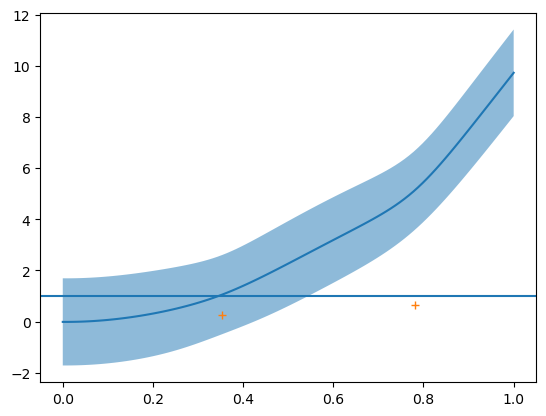

In [4]:
gp = SingleTaskGP(
    train_X, train_Y,
    mean_module=custom_mean,
    input_transform=input_transform,
    outcome_transform=outcome_transform
)
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
fit_gpytorch_mll(mll)

import matplotlib.pyplot as plt
# visualize
test_x = torch.linspace(0,1,100)

with torch.no_grad():
    post = gp.posterior(test_x.unsqueeze(1))
    mean = post.mean.flatten()
    l,u = post.mvn.confidence_region()

    fig,ax = plt.subplots()
    ax.plot(test_x, mean.numpy())
    ax.fill_between(test_x, l.flatten(), u.flatten(), alpha=0.5)
    ax.plot(train_X.flatten(), train_Y.flatten(), "+")
    ax.axhline(1.0)